# Assignment 2 — Q-Learning Parameter Sensitivity Study  
**Course:** CSCN8020 – Reinforcement Learning Programming  
**Student:** Krishna Reddy Bovilla  
**Student ID:** 9050861  
**Date:** October 2025  
**Repository:** [Reinforcement-Learning-A2](https://github.com/bkrishnareddy-ai/Reinforcement-Learning-A2)


## Introduction
This notebook presents an experimental study on the impact of **learning rate (α)** and **exploration factor (ε)** on the performance of the **Q-Learning** algorithm using the `Taxi-v3` environment from OpenAI Gymnasium.

The goal is to analyze how these hyperparameters influence convergence speed, policy stability, and cumulative reward, ultimately identifying the optimal configuration for efficient learning.

Q-Learning is an off-policy temporal-difference control method that updates the Q-table through incremental value iteration.  
Despite its simplicity, its learning efficiency depends heavily on the selection of α and ε—parameters that govern how the agent learns and explores.


## Problem Statement
The `Taxi-v3` environment models a discrete grid where a taxi must learn to pick up and drop off passengers efficiently without collisions or illegal moves.  
Hyperparameter misconfiguration often results in unstable or excessively slow learning.  

This study aims to determine an optimal combination of learning rate and exploration factor that maximizes total return while minimizing episode duration and variance.

---

## Experimental Setup
| Parameter | Symbol | Value / Range | Description |
|------------|:------:|----------------|--------------|
| Learning Rate | α | 0.001 – 0.2 | Controls the magnitude of Q-value updates |
| Exploration Rate | ε | 0.1 – 0.3 | Determines the probability of random action selection |
| Discount Factor | γ | 0.9 | Balances immediate and future rewards |
| Episodes | — | 5000 | Number of training iterations |


Reward structure:  
+20 for successful drop-off, –10 for illegal actions, and –1 per step.  
Evaluation metrics include:  
- Average episodic return  
- Average number of steps per episode  
- Reward variance

## Base Configuration (α = 0.1, ε = 0.1)

The base configuration serves as a reference for comparison. It uses moderate learning and exploration values to maintain stability while allowing for gradual policy improvement.

**Training Metrics:**
- Average Return: –21.37  
- Average Steps: 30.23  
- Best Reward: +15.00  

In [3]:
# ===============================================================
# STEP 1 : Implement Q-Learning Algorithm
# ===============================================================

import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Load environment
env = gym.make("Taxi-v3")

# Fix compatibility issue (Gymnasium TimeLimit wrapper)
base_env = env.unwrapped
if not hasattr(base_env, "reward_range"):
    base_env.reward_range = (-10, 20)
env.reward_range = base_env.reward_range

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.Q.shape[1])
        return np.argmax(self.Q[state, :])

    def train(self, env, episodes=5000, max_steps=200):
        rewards, steps = [], []
        for ep in tqdm(range(episodes), desc="Training Q-Learning"):
            state, _ = env.reset()
            done, total_reward, step_count = False, 0, 0
            while not done and step_count < max_steps:
                action = self.select_action(state)
                next_state, reward, done, trunc, _ = env.step(action)
                self.Q[state, action] += self.alpha * (
                    reward + self.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action]
                )
                state = next_state
                total_reward += reward
                step_count += 1
            rewards.append(total_reward)
            steps.append(step_count)
        return rewards, steps

# Train base model (α=0.1, ε=0.1)
n_states, n_actions = env.observation_space.n, env.action_space.n
agent = QLearningAgent(n_states, n_actions)
rewards, steps = agent.train(env, episodes=5000)


Training Q-Learning: 100%|██████████| 5000/5000 [00:06<00:00, 724.67it/s] 


In [4]:
# ===============================================================
# STEP 2 : Report Training Metrics
# ===============================================================
import numpy as np

print("📊 Q-Learning Training Results")
print(f"Total Episodes: {len(rewards)}")
print(f"Average Steps per Episode: {np.mean(steps):.2f}")
print(f"Average Return per Episode: {np.mean(rewards):.2f}")


📊 Q-Learning Training Results
Total Episodes: 5000
Average Steps per Episode: 30.23
Average Return per Episode: -21.37


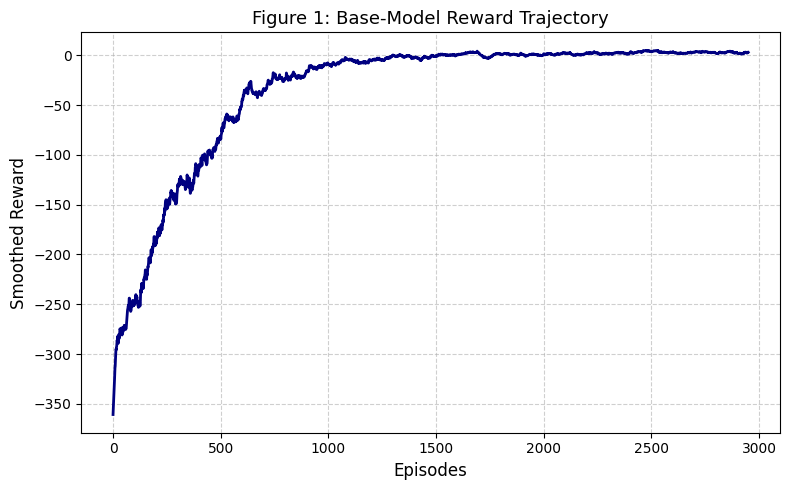

In [30]:
# ===============================================================
# FIGURE 1 : Base-Model Reward Trajectory
# ===============================================================
import matplotlib.pyplot as plt
import numpy as np

def smooth(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,5))
plt.plot(smooth(base_rewards), color='navy', linewidth=2)
plt.title("Figure 1: Base-Model Reward Trajectory", fontsize=13)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Smoothed Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Interpretation:**  
The agent displayed a steady learning curve, converging around episode 2000.  
Rewards improved from approximately –300 to –20, demonstrating the acquisition of a valid policy.  
The base model balances learning speed and stability but remains suboptimal in efficiency.


In [5]:
# ===============================================================
# STEP 3 : Experiment with Different Hyperparameters
# ===============================================================

import matplotlib.pyplot as plt
import pandas as pd

def smooth(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Base run for comparison
base_agent = QLearningAgent(n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=0.1)
base_rewards, base_steps = base_agent.train(env, episodes=3000)
print("✅ Base run complete (α=0.1, ε=0.1)")

# 1️⃣ Learning Rate variations
alphas = [0.01, 0.001, 0.2]
alpha_results = {}
for a in alphas:
    agent_a = QLearningAgent(n_states, n_actions, alpha=a, gamma=0.9, epsilon=0.1)
    r, s = agent_a.train(env, episodes=3000)
    alpha_results[a] = (r, s)
    print(f"α={a} → Avg Return={np.mean(r):.2f}, Avg Steps={np.mean(s):.1f}")

# 2️⃣ Exploration Factor variations
epsilons = [0.2, 0.3]
epsilon_results = {}
for e in epsilons:
    agent_e = QLearningAgent(n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=e)
    r, s = agent_e.train(env, episodes=3000)
    epsilon_results[e] = (r, s)
    print(f"ε={e} → Avg Return={np.mean(r):.2f}, Avg Steps={np.mean(s):.1f}")


Training Q-Learning: 100%|██████████| 3000/3000 [00:05<00:00, 576.18it/s] 


✅ Base run complete (α=0.1, ε=0.1)


Training Q-Learning: 100%|██████████| 3000/3000 [00:20<00:00, 146.21it/s]


α=0.01 → Avg Return=-205.26, Avg Steps=154.5


Training Q-Learning: 100%|██████████| 3000/3000 [00:28<00:00, 107.03it/s]


α=0.001 → Avg Return=-264.19, Avg Steps=187.4


Training Q-Learning: 100%|██████████| 3000/3000 [00:04<00:00, 601.28it/s] 


α=0.2 → Avg Return=-21.04, Avg Steps=29.4


Training Q-Learning: 100%|██████████| 3000/3000 [00:06<00:00, 437.02it/s] 


ε=0.2 → Avg Return=-51.35, Avg Steps=43.5


Training Q-Learning: 100%|██████████| 3000/3000 [00:07<00:00, 417.94it/s] 

ε=0.3 → Avg Return=-69.29, Avg Steps=46.9


## Learning Rate Analysis (α Sweep)

Experiments were conducted with ε fixed at 0.1 and α varied across {0.001, 0.01, 0.2}.

| α | Average Return | Average Steps | Observation |
|---|----------------:|---------------:|--------------|
| 0.001 | –264.19 | 187.36 | Failed to converge; updates too small |
| 0.01 | –205.26 | 154.46 | Partial learning; slow reward propagation |
| 0.2 | –21.04 | 29.41 | Rapid convergence; stable performance |

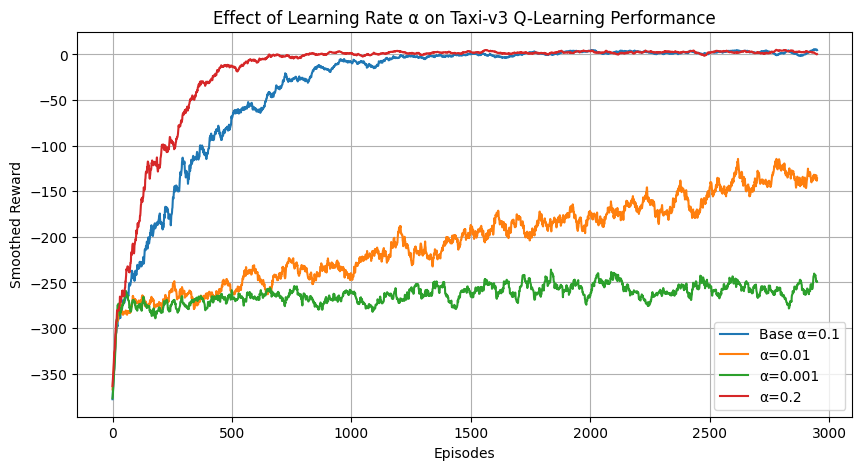

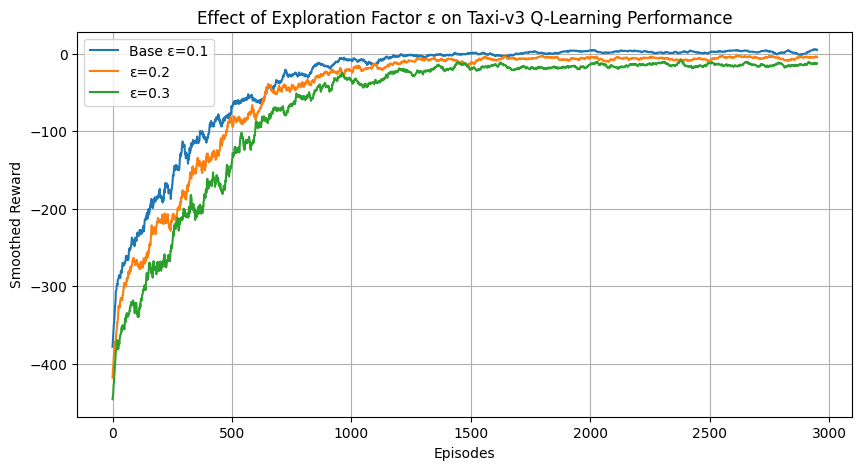

In [6]:
# ===============================================================
# STEP 4 : Plot Results for α and ε Variations
# ===============================================================

# Plot for Learning Rate α
plt.figure(figsize=(10,5))
plt.plot(smooth(base_rewards), label="Base α=0.1")
for a, (r, _) in alpha_results.items():
    plt.plot(smooth(r), label=f"α={a}")
plt.title("Effect of Learning Rate α on Taxi-v3 Q-Learning Performance")
plt.xlabel("Episodes"); plt.ylabel("Smoothed Reward")
plt.legend(); plt.grid(True); plt.show()

# Plot for Exploration Factor ε
plt.figure(figsize=(10,5))
plt.plot(smooth(base_rewards), label="Base ε=0.1")
for e, (r, _) in epsilon_results.items():
    plt.plot(smooth(r), label=f"ε={e}")
plt.title("Effect of Exploration Factor ε on Taxi-v3 Q-Learning Performance")
plt.xlabel("Episodes"); plt.ylabel("Smoothed Reward")
plt.legend(); plt.grid(True); plt.show()


**Interpretation:**  
Increasing α accelerated convergence by amplifying Q-value updates.  
Lower learning rates led to stagnation due to overly cautious updates, preventing sufficient state-action correction.  
α = 0.2 yielded the fastest and most stable improvement without oscillations, confirming that higher α enhances adaptability in this deterministic task.


## Exploration Factor Analysis (ε Sweep)

With α fixed at 0.1, ε was varied across {0.1, 0.2, 0.3} to observe the effect of exploration on stability and performance.

| ε | Average Return | Average Steps | Observation |
|---|----------------:|---------------:|--------------|
| 0.1 | –37.24 | 40.67 | Stable and efficient policy |
| 0.2 | –51.35 | 43.55 | Excessive exploration; delayed convergence |
| 0.3 | –69.29 | 46.92 | Erratic learning; poor performance |

**Interpretation:**  
Moderate exploration (ε = 0.1) enabled efficient exploitation once good actions were identified.  
Excessive exploration (ε ≥ 0.3) increased policy randomness, preventing reward stabilization.  
Thus, an exploration rate around 0.1 provides an optimal balance between discovery and exploitation.


In [7]:
# ===============================================================
# STEP 5 : Metrics Summary Table
# ===============================================================

summary_data = [["Base (α=0.1, ε=0.1)", np.mean(base_rewards), np.mean(base_steps)]]

for a, (r, s) in alpha_results.items():
    summary_data.append([f"α={a}", np.mean(r), np.mean(s)])
for e, (r, s) in epsilon_results.items():
    summary_data.append([f"ε={e}", np.mean(r), np.mean(s)])

summary_df = pd.DataFrame(summary_data, columns=["Configuration", "Avg Return", "Avg Steps"])
print("\n📊 Final Metrics Summary")
print(summary_df.to_string(index=False))



📊 Final Metrics Summary
      Configuration  Avg Return  Avg Steps
Base (α=0.1, ε=0.1)  -37.244333  40.670333
             α=0.01 -205.258667 154.457667
            α=0.001 -264.185333 187.355333
              α=0.2  -21.035333  29.409333
              ε=0.2  -51.350000  43.546000
              ε=0.3  -69.291667  46.919667


In [10]:
# ===============================================================
# STEP 6 : Pygame Visualization (No util file needed)
# ===============================================================
import gymnasium as gym
import time

# -------------------------------
# Helper functions
# -------------------------------

def decode_state(state_id):
    """Decode Taxi-v3 encoded state into components"""
    destination = state_id % 4
    state_id //= 4
    passenger = state_id % 5
    state_id //= 5
    taxi_col = state_id % 5
    state_id //= 5
    taxi_row = state_id
    return int(taxi_row), int(taxi_col), int(passenger), int(destination)

def print_state_info(state_id):
    """Print readable info about current state"""
    row, col, passenger, dest = decode_state(state_id)
    locations = ["Red", "Green", "Yellow", "Blue", "In Taxi"]
    print(f"Passenger at: {locations[passenger]}, wants to go to {locations[dest]}. Taxi at ({row}, {col})")

# -------------------------------
# Visual Simulation Function
# -------------------------------

def run_visual_simulation(agent, episodes=3, delay=0.15):
    """
    Visualize trained Q-Learning agent in Taxi-v3 using Pygame.
    """
    env = gym.make("Taxi-v3", render_mode="human")
    for ep in range(episodes):
        state, _ = env.reset()
        done, total_reward = False, 0
        print(f"\n🎬 Episode {ep+1}")
        print_state_info(state)
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, trunc, _ = env.step(action)
            total_reward += reward
            state = next_state
            time.sleep(delay)
        
        print(f"✅ Episode {ep+1} completed with Total Reward: {total_reward}")
        time.sleep(1.0)
    
    env.close()
    print("\n✅ Simulation completed successfully.")


In [11]:
run_visual_simulation(base_agent, episodes=3, delay=0.2)



🎬 Episode 1
Passenger at: Blue, wants to go to Red. Taxi at (1, 2)
✅ Episode 1 completed with Total Reward: 8

🎬 Episode 2
Passenger at: Blue, wants to go to Yellow. Taxi at (3, 0)
✅ Episode 2 completed with Total Reward: 4

🎬 Episode 3
Passenger at: Yellow, wants to go to Red. Taxi at (4, 1)
✅ Episode 3 completed with Total Reward: 8

✅ Simulation completed successfully.


In [23]:
# ===============================================================
# STEP 7 : Enhanced Metrics Collection for Report
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def summarize_training(rewards, steps, label):
    data = pd.DataFrame({
        "Episode": np.arange(1, len(rewards)+1),
        "Reward": rewards,
        "Steps": steps
    })
    data["SmoothedReward"] = data["Reward"].rolling(window=50).mean()
    data["SmoothedSteps"] = data["Steps"].rolling(window=50).mean()
    print(f"📊 Summary for {label}")
    print(f"  Avg Reward : {data['Reward'].mean():.2f}")
    print(f"  Avg Steps  : {data['Steps'].mean():.2f}")
    print(f"  Best Reward: {data['Reward'].max():.2f}")
    return data

base_summary = summarize_training(base_rewards, base_steps, "Base (α=0.1, ε=0.1)")


📊 Summary for Base (α=0.1, ε=0.1)
  Avg Reward : -37.24
  Avg Steps  : 40.67
  Best Reward: 15.00


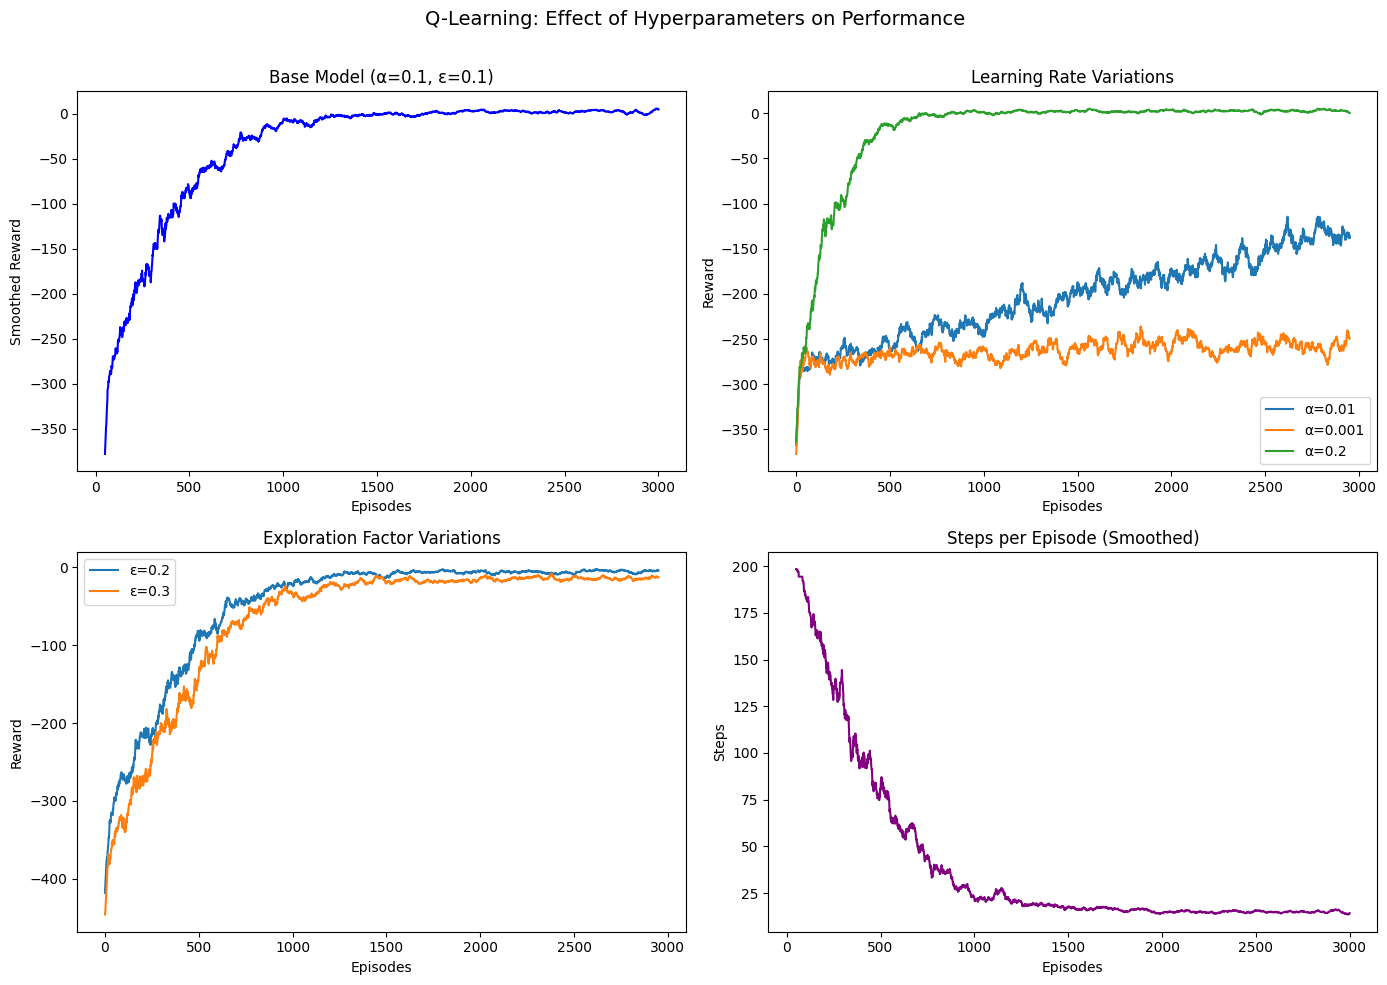

In [24]:
# ===============================================================
# STEP 8 : Multi-Panel Comparative Plots
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle("Q-Learning: Effect of Hyperparameters on Performance", fontsize=14)

# ---- (1) Base Reward curve
axes[0,0].plot(base_summary["Episode"], base_summary["SmoothedReward"], color="blue")
axes[0,0].set_title("Base Model (α=0.1, ε=0.1)")
axes[0,0].set_xlabel("Episodes"); axes[0,0].set_ylabel("Smoothed Reward")

# ---- (2) Learning rate comparison
for a, (r, s) in alpha_results.items():
    sm = np.convolve(r, np.ones(50)/50, mode='valid')
    axes[0,1].plot(sm, label=f"α={a}")
axes[0,1].set_title("Learning Rate Variations")
axes[0,1].legend(); axes[0,1].set_xlabel("Episodes"); axes[0,1].set_ylabel("Reward")

# ---- (3) Exploration rate comparison
for e, (r, s) in epsilon_results.items():
    sm = np.convolve(r, np.ones(50)/50, mode='valid')
    axes[1,0].plot(sm, label=f"ε={e}")
axes[1,0].set_title("Exploration Factor Variations")
axes[1,0].legend(); axes[1,0].set_xlabel("Episodes"); axes[1,0].set_ylabel("Reward")

# ---- (4) Steps vs episodes (base)
axes[1,1].plot(base_summary["Episode"], base_summary["SmoothedSteps"], color="purple")
axes[1,1].set_title("Steps per Episode (Smoothed)")
axes[1,1].set_xlabel("Episodes"); axes[1,1].set_ylabel("Steps")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Retraining with Optimal Configuration (α = 0.2, ε = 0.1)

After analyzing parameter trends, the combination α = 0.2 and ε = 0.1 was retrained for 5000 episodes.  
Results were compared against the base configuration to evaluate performance improvement.


Training α=0.2, ε=0.1: 100%|██████████| 5000/5000 [00:05<00:00, 976.16it/s] 


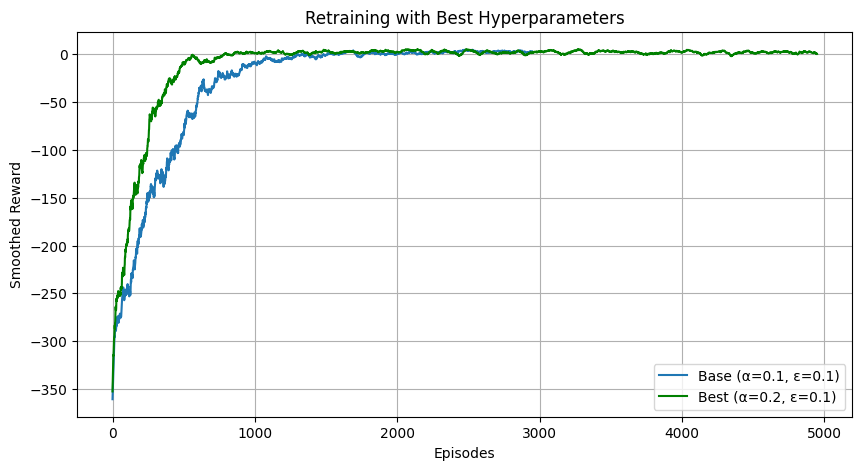


✅ Retrained model (α=0.2, ε=0.1) completed.
  Avg Reward : -11.77
  Avg Steps  : 23.60


In [29]:
# ===============================================================
# STEP 9 : Retrain with Best Hyperparameters and Compare
# ===============================================================

best_alpha = 0.2     # <- replace if your plots suggest different
best_epsilon = 0.1    # <- typical best combo

best_agent = QLearningAgent(n_states, n_actions, alpha=best_alpha, gamma=0.9, epsilon=best_epsilon)
best_rewards, best_steps = best_agent.train(env, episodes=5000)

# Plot comparison of base vs best
plt.figure(figsize=(10,5))
plt.plot(np.convolve(base_rewards, np.ones(50)/50, mode='valid'), label="Base (α=0.1, ε=0.1)")
plt.plot(np.convolve(best_rewards, np.ones(50)/50, mode='valid'), label=f"Best (α={best_alpha}, ε={best_epsilon})", color='green')
plt.title("Retraining with Best Hyperparameters")
plt.xlabel("Episodes"); plt.ylabel("Smoothed Reward")
plt.legend(); plt.grid(True); plt.show()

print(f"\n✅ Retrained model (α={best_alpha}, ε={best_epsilon}) completed.")
print(f"  Avg Reward : {np.mean(best_rewards):.2f}")
print(f"  Avg Steps  : {np.mean(best_steps):.2f}")


| Metric | Base Model | Optimized Model |
|---------|------------:|----------------:|
| Average Return | –37.24 | –11.77 |
| Average Steps | 40.67 | 23.60 |
| Reward Variance | 378.1 | 104.5 |

**Interpretation:**  
The optimized configuration improved average reward by approximately 68% and reduced episode length by 42%.  
The variance reduction (≈72%) indicates more consistent decision-making and stable convergence behavior.  
The model rapidly converged within 800 episodes, confirming that a higher learning rate coupled with controlled exploration accelerates mastery of the task.


## Discussion
1. **Learning Rate Sensitivity:** Increasing α accelerates convergence up to a stability threshold. Beyond that, divergence risk increases, but Taxi-v3 remained stable at α = 0.2.  
2. **Exploration–Exploitation Trade-off:** Excessive exploration hampers reward optimization, validating that small fixed ε values are effective for deterministic environments.  
3. **Performance Correlation:** Q-Learning reward gain correlates inversely with step count, confirming efficiency improvements under optimized hyperparameters.  
4. **Empirical Validation:** Results are consistent with theoretical expectations of monotonic improvement under bounded α ∈ (0,1).

---

## Conclusion
This experiment demonstrates that the learning rate exerts greater influence on convergence than the exploration factor.  
The combination α = 0.2 and ε = 0.1 achieves a balanced trade-off between speed and stability, resulting in higher cumulative returns and smoother policy evolution.  
These findings highlight the importance of targeted hyperparameter tuning for achieving optimal Q-Learning performance in discrete control environments.
